In [27]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [28]:
dataset = TSD(categories=['sc'], file_path="../datasets/power_transitions.csv")
dataset.scv_imputed = pd.DataFrame()


Dataset loaded from ../datasets/power_transitions.xlsx


In [29]:
imp_columns =  ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(imp_columns, use_duplicates=False)
sc_columns = ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']

pca = dataset.compute_PCA(imp_columns, 'PC', n_cols = 2, n_PCA = 8)

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 76.25%
PC2: 5.73%
PC3: 5.55%
PC4: 3.50%
PC5: 2.90%
PC6: 2.65%
PC7: 1.95%
PC8: 1.47%


In [30]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
for var in crisis_vars:
    dataset.scv_imputed[var] = dataset.raw[var]
dataset.scv_imputed.dropna(subset=imp_columns, inplace=True)

In [31]:
pca = dataset.compute_PCA(imp_columns, 'PC', n_cols = 2, n_PCA = 8, contributions=True)

Explained variance by each PC:
PC1: 76.25%
PC2: 5.73%
PC3: 5.55%
PC4: 3.50%
PC5: 2.90%
PC6: 2.65%
PC7: 1.95%
PC8: 1.47%
PC1 contributions:
Pop: -0.37
Cap: -0.38
Terr: -0.34
Hierarchy: -0.33
Government: -0.35
Infrastructure: -0.36
Information: -0.36
Money: -0.34
PC1 contributions:
Pop: -0.36
Cap: -0.15
Terr: -0.67
Hierarchy: 0.28
Government: 0.48
Infrastructure: 0.21
Information: 0.21
Money: 0.02


In [33]:
n_bins = 20

pc1 = np.linspace(dataset.scv_imputed.PC_1.min(), dataset.scv_imputed.PC_1.max(), n_bins)
delta = (pc1[1] - pc1[0])
pc2 = np.zeros(n_bins)
pc2_std = np.zeros(n_bins)

crisis = np.zeros((len(crisis_vars),n_bins))


for i in range(n_bins):
    pc2[i] = dataset.scv_imputed.loc[(dataset.scv_imputed.PC_1 >= pc1[i]-delta) & (dataset.scv_imputed.PC_1 < pc1[i]+delta), 'PC_2'].dropna().mean()
    pc2_std[i] = dataset.scv_imputed.loc[(dataset.scv_imputed.PC_1 >= pc1[i]-delta) & (dataset.scv_imputed.PC_1 < pc1[i]+delta), 'PC_2'].dropna().std()
    for v in range(len(crisis_vars)):
        crisis[v,i] = dataset.scv_imputed.loc[(dataset.scv_imputed.PC_1 >= pc1[i]-delta) & (dataset.scv_imputed.PC_1 < pc1[i]+delta), crisis_vars[v]].dropna().mean()

<ErrorbarContainer object of 3 artists>

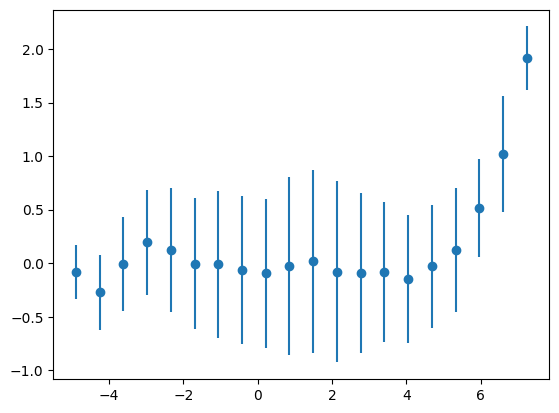

In [35]:
plt.errorbar(pc1, pc2, yerr=pc2_std, fmt='o')

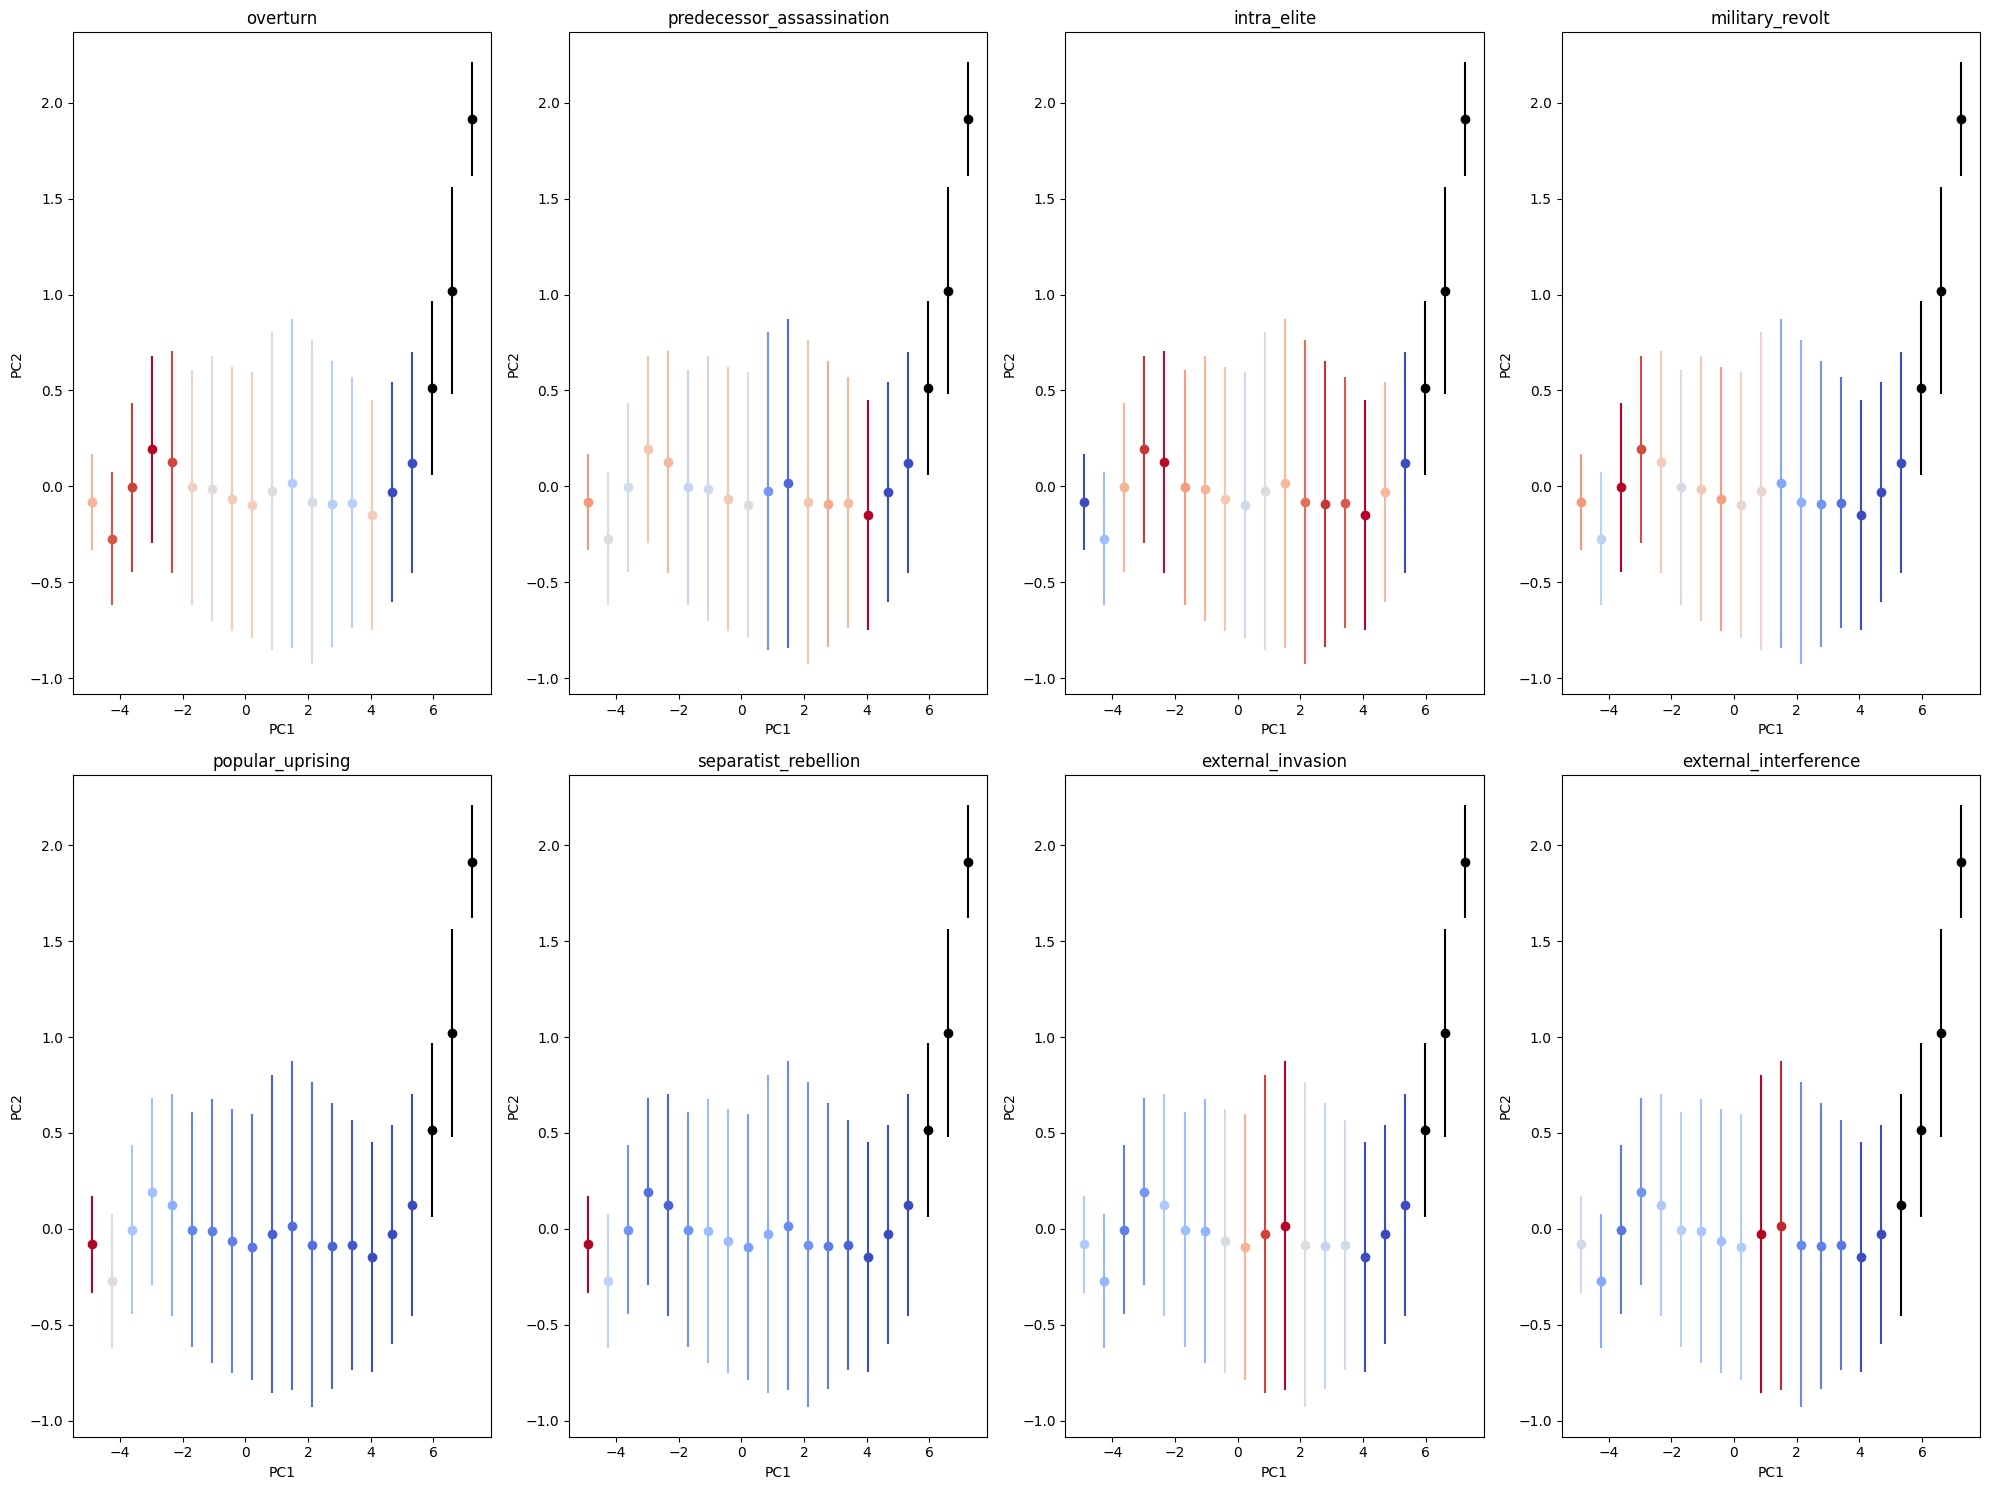

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
axes = axes.flatten()

for v in range(len(crisis_vars)):
    # Normalize the crisis values to use with a colormap
    norm = crisis / crisis.max()
    cmap = plt.get_cmap('coolwarm')

    # Plot the error bars with colors based on the crisis values
    for i in range(len(pc1)):
        axes[v].errorbar(pc1[i], pc2[i], yerr=pc2_std[i], fmt='o', color=cmap(crisis[v, i] / max(crisis[v, :])))
        if pd.isna(crisis[v, i]):
            axes[v].errorbar(pc1[i], pc2[i], yerr=pc2_std[i], fmt='o', color='black')
    axes[v].set_xlabel('PC1')
    axes[v].set_ylabel('PC2')
    axes[v].set_title(crisis_vars[v])

plt.tight_layout()
plt.show()

In [9]:
crisis/max(crisis)


array([0.        , 0.2244898 , 0.42672414, 0.46857143, 0.38181818,
       0.30495868, 0.25942029, 0.28333333, 0.43571429, 0.45      ,
       0.42      , 1.        ,        nan,        nan,        nan])